# Training Model

In [ ]:
import sys
import os

# Add the 'src' directory to Python's module search path
src_dir = os.path.abspath(os.path.join("..", "src"))  # Goes up to 'Challenge #1', then into 'src'
sys.path.append(src_dir)

Successfully imported SoilClassification!


In [5]:
import sys
print(sys.executable)  # Shows which Python interpreter is running your code

e:\AnnamAI\new_push_gith\venv\Scripts\python.exe


In [41]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import time
import torch
from torch import nn
import numpy as np
from essentials import SoilClassification, TinyVGG
from torchvision import transforms
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from collections import Counter
from torch.utils.data import random_split, WeightedRandomSampler, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import json

torch.__version__

'2.7.0+cu118'

In [9]:
soil_classification_path = Path(r"../data/data/soil_classification-2025")
print(soil_classification_path.exists())

True


In [10]:
soil_classification_path

WindowsPath('../data/data/soil_classification-2025')

In [11]:
train_csv = soil_classification_path / "train_labels.csv"
print(train_csv.exists()) # Initial Checks

True


In [12]:
train_csv

WindowsPath('../data/data/soil_classification-2025/train_labels.csv')

In [13]:
train_df = pd.read_csv(train_csv)
train_df.head() # image name , category

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


In [14]:
transform = transforms.Compose( # Compose methods just binds all the transformations together, can be called to invoke those respective tranformations at once
    [
        transforms.Resize((224, 224)), # Resizes to common 224 x 224 dimension to all images in dataset
        transforms.ToTensor(), # Converts the PIL image to Tensor image which is the requirement of model while training
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes the images [worked well]
    ]
)

In [15]:
# Instatinating SoilClassification class

data = SoilClassification(
    df = train_df,
    root_dir = soil_classification_path,
    transform = transform,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3687146..1.3606442].


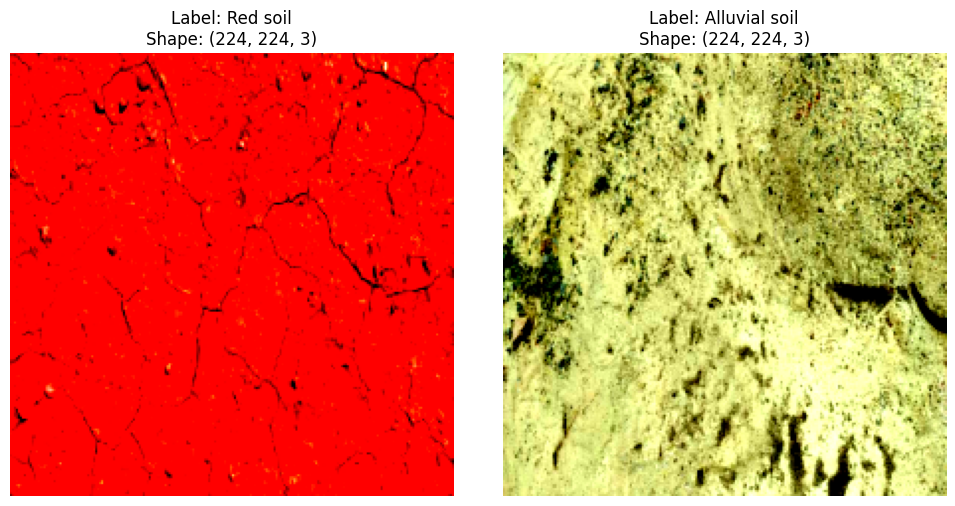

In [16]:
data.show_batch(2) # Critical - Shows transformed/augmented image rather than provided train images

In [17]:
data.cls_to_idx

{'Alluvial soil': 0, 'Black Soil': 1, 'Clay soil': 2, 'Red soil': 3}

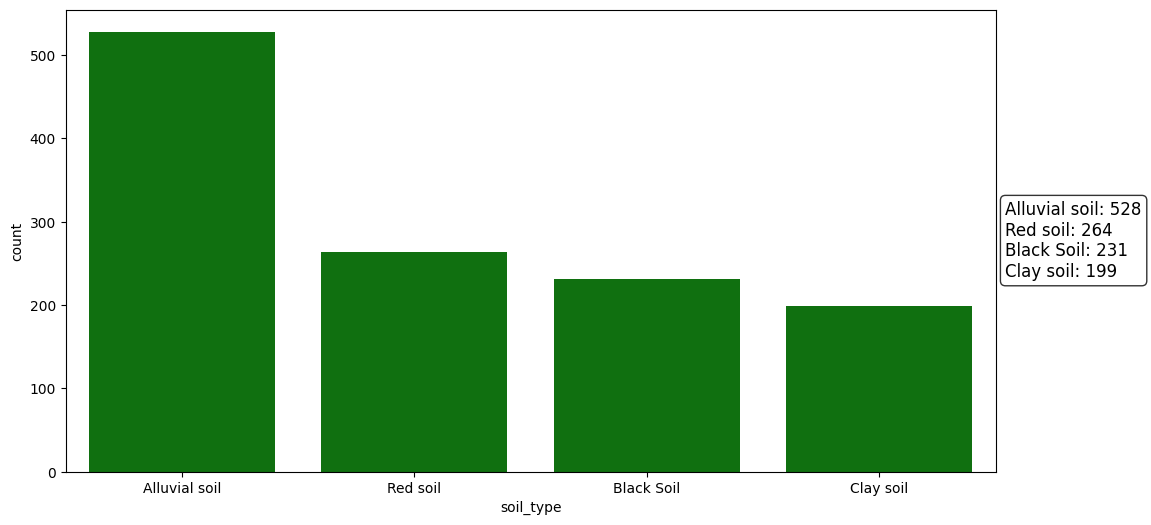

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(ax=ax, x=train_df['soil_type'].value_counts().index,
            y=train_df['soil_type'].value_counts().values,
            color='green')

counts_str = "\n".join([f"{soil}: {count}" for soil, count in train_df['soil_type'].value_counts().items()])
ax.text(1.0105, 0.5, counts_str, transform=ax.transAxes,  # Axes-relative coordinates
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'),
        fontsize=12, va='center')

plt.xlabel('soil_type')
plt.ylabel('count')
plt.show() # Conclusion - Alluvial soil appears more numbers of times than that of average number of times rest 3 are occuring

In [21]:
# Train-Test splt

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_size, test_size

(977, 245)

In [25]:
labels = []
for i in range(977):
  labels.append(train_dataset[i][1]) # Stores each image's label

class_counter = Counter(labels) # Same labels are aggregated to give overall statistics of how many example belong to a specific class
total_samples = len(train_df)

class_weights = {cls:total_samples / count for cls,count in class_counter.items()} # Class Weights calculate based on above knowledge

In [26]:
class_weights

{3: 5.764150943396227,
 0: 2.8091954022988506,
 1: 6.903954802259887,
 2: 7.9869281045751634}

In [29]:
# Assign a weight for each sample

sample_weights = [class_weights[label] for label in labels]
sample_weights = torch.DoubleTensor(sample_weights) # Convert back to tensor double currently float

len(sample_weights) == len(labels) # Sanity check

True

In [30]:
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True) # Initialised sampler

In [32]:
# Batchifying the data
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    #shuffle = True, ## MUTUALLY EXCLUSIVE SAMPLER AND SHUFFLE
    sampler = sampler,
    num_workers = 0,
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    shuffle = False,
    num_workers = 0,
)

print(train_dataloader)
print(test_dataloader)

# Training

In [38]:
# ||||||||||||||||| TRAINING PHASE ||||||||||||||||||||||

EPOCHS = 50
criterion = nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else 'cpu'
model_vo_ = TinyVGG(3,10,4).to(device) # Throwing model to GPU, if available

optimizer = torch.optim.Adam(model_vo_.parameters(), lr=0.0001, weight_decay=1e-7) #97.96 epoch 34

#optimizer = Lion(model_vo_.parameters(), lr=0.0002, weight_decay=1e-0)



results = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': [],
    'epoch_time': []
}
best_acc = 0.0

for epoch in range(EPOCHS):
    start_time = time.time()
    model_vo_.train()
    train_loss, train_acc = 0.0, 0.0

    # --- Training Phase ---
    for X, y in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model_vo_(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(y_pred, dim=1) == y).sum().item()  # Count correct

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)  # Normalize by TOTAL SAMPLES

    # --- Validation Phase ---
    model_vo_.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            X, y = X.to(device), y.to(device)
            y_pred = model_vo_(X)
            test_loss += criterion(y_pred, y).item()
            test_acc += (torch.argmax(y_pred, dim=1) == y).sum().item()

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader.dataset)  # Normalize by TOTAL SAMPLES

    # --- Epoch Logging ---
    epoch_time = time.time() - start_time
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model_vo_.state_dict(), "best_model.pth")
        print(f"  ✅ Best model saved (Acc: {best_acc*100:.2f}%)")

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    results['epoch_time'].append(epoch_time)

    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f} | Acc:  {test_acc*100:.2f}%")
    print(f"  Time: {epoch_time:.2f}s\n")

print(f"\nBest Test Accuracy: {best_acc*100:.2f}%")




Epoch 1/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.97it/s]


  ✅ Best model saved (Acc: 77.14%)

Epoch 1/50:
  Train Loss: 0.9480 | Acc: 64.18%
  Test Loss:  0.7036 | Acc:  77.14%
  Time: 4.07s



Epoch 2/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.87it/s]



Epoch 2/50:
  Train Loss: 0.5670 | Acc: 78.10%
  Test Loss:  0.6415 | Acc:  73.88%
  Time: 3.86s



Epoch 3/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.61it/s]



Epoch 3/50:
  Train Loss: 0.4230 | Acc: 82.80%
  Test Loss:  0.4342 | Acc:  77.14%
  Time: 3.86s



Epoch 4/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.48it/s]


  ✅ Best model saved (Acc: 84.49%)

Epoch 4/50:
  Train Loss: 0.3482 | Acc: 86.28%
  Test Loss:  0.4002 | Acc:  84.49%
  Time: 3.88s



Epoch 5/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.39it/s]



Epoch 5/50:
  Train Loss: 0.2947 | Acc: 87.41%
  Test Loss:  0.3636 | Acc:  83.67%
  Time: 3.85s



Epoch 6/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.81it/s]


  ✅ Best model saved (Acc: 86.12%)

Epoch 6/50:
  Train Loss: 0.2701 | Acc: 89.15%
  Test Loss:  0.3512 | Acc:  86.12%
  Time: 3.86s



Epoch 7/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.92it/s]


  ✅ Best model saved (Acc: 87.76%)

Epoch 7/50:
  Train Loss: 0.2472 | Acc: 89.87%
  Test Loss:  0.3448 | Acc:  87.76%
  Time: 3.90s



Epoch 8/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.44it/s]


  ✅ Best model saved (Acc: 88.16%)

Epoch 8/50:
  Train Loss: 0.1898 | Acc: 93.96%
  Test Loss:  0.3267 | Acc:  88.16%
  Time: 3.89s



Epoch 9/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.35it/s]



Epoch 9/50:
  Train Loss: 0.1577 | Acc: 94.58%
  Test Loss:  0.5075 | Acc:  80.41%
  Time: 3.88s



Epoch 10/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.50it/s]



Epoch 10/50:
  Train Loss: 0.1731 | Acc: 93.86%
  Test Loss:  0.4175 | Acc:  84.90%
  Time: 3.87s



Epoch 11/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.18it/s]


  ✅ Best model saved (Acc: 92.24%)

Epoch 11/50:
  Train Loss: 0.2002 | Acc: 92.84%
  Test Loss:  0.2352 | Acc:  92.24%
  Time: 3.89s



Epoch 12/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


  ✅ Best model saved (Acc: 93.47%)

Epoch 12/50:
  Train Loss: 0.1421 | Acc: 94.68%
  Test Loss:  0.2287 | Acc:  93.47%
  Time: 3.92s



Epoch 13/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.66it/s]



Epoch 13/50:
  Train Loss: 0.1203 | Acc: 96.72%
  Test Loss:  0.2551 | Acc:  90.20%
  Time: 3.88s



Epoch 14/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.95it/s]



Epoch 14/50:
  Train Loss: 0.1098 | Acc: 96.21%
  Test Loss:  0.2504 | Acc:  92.24%
  Time: 3.87s



Epoch 15/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.44it/s]



Epoch 15/50:
  Train Loss: 0.0927 | Acc: 98.06%
  Test Loss:  0.2068 | Acc:  93.06%
  Time: 3.90s



Epoch 16/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


  ✅ Best model saved (Acc: 94.69%)

Epoch 16/50:
  Train Loss: 0.0964 | Acc: 97.44%
  Test Loss:  0.2178 | Acc:  94.69%
  Time: 3.91s



Epoch 17/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.16it/s]



Epoch 17/50:
  Train Loss: 0.0632 | Acc: 98.77%
  Test Loss:  0.2303 | Acc:  93.47%
  Time: 3.91s



Epoch 18/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.93it/s]



Epoch 18/50:
  Train Loss: 0.0805 | Acc: 97.65%
  Test Loss:  0.2351 | Acc:  91.84%
  Time: 3.92s



Epoch 19/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.90it/s]



Epoch 19/50:
  Train Loss: 0.1172 | Acc: 96.01%
  Test Loss:  0.2592 | Acc:  91.84%
  Time: 3.90s



Epoch 20/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.47it/s]


  ✅ Best model saved (Acc: 95.10%)

Epoch 20/50:
  Train Loss: 0.0685 | Acc: 98.46%
  Test Loss:  0.1962 | Acc:  95.10%
  Time: 3.91s



Epoch 21/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.26it/s]



Epoch 21/50:
  Train Loss: 0.0567 | Acc: 98.67%
  Test Loss:  0.2036 | Acc:  93.47%
  Time: 3.88s



Epoch 22/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.10it/s]



Epoch 22/50:
  Train Loss: 0.0524 | Acc: 98.87%
  Test Loss:  0.2096 | Acc:  92.24%
  Time: 3.89s



Epoch 23/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.53it/s]


  ✅ Best model saved (Acc: 96.33%)

Epoch 23/50:
  Train Loss: 0.0606 | Acc: 97.85%
  Test Loss:  0.1866 | Acc:  96.33%
  Time: 3.92s



Epoch 24/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.42it/s]



Epoch 24/50:
  Train Loss: 0.0523 | Acc: 98.16%
  Test Loss:  0.1891 | Acc:  94.69%
  Time: 3.92s



Epoch 25/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.43it/s]



Epoch 25/50:
  Train Loss: 0.0436 | Acc: 98.26%
  Test Loss:  0.1887 | Acc:  95.10%
  Time: 3.92s



Epoch 26/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.55it/s]



Epoch 26/50:
  Train Loss: 0.0459 | Acc: 98.67%
  Test Loss:  0.1744 | Acc:  95.92%
  Time: 3.92s



Epoch 27/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.21it/s]



Epoch 27/50:
  Train Loss: 0.0703 | Acc: 97.95%
  Test Loss:  0.2486 | Acc:  93.88%
  Time: 3.93s



Epoch 28/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.02it/s]



Epoch 28/50:
  Train Loss: 0.0741 | Acc: 97.85%
  Test Loss:  0.2126 | Acc:  93.06%
  Time: 3.93s



Epoch 29/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.54it/s]



Epoch 29/50:
  Train Loss: 0.0383 | Acc: 98.67%
  Test Loss:  0.1565 | Acc:  96.33%
  Time: 3.92s



Epoch 30/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]



Epoch 30/50:
  Train Loss: 0.0536 | Acc: 98.26%
  Test Loss:  0.1478 | Acc:  95.92%
  Time: 3.91s



Epoch 31/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]



Epoch 31/50:
  Train Loss: 0.0355 | Acc: 98.87%
  Test Loss:  0.1619 | Acc:  95.10%
  Time: 3.94s



Epoch 32/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 19.96it/s]



Epoch 32/50:
  Train Loss: 0.0388 | Acc: 98.98%
  Test Loss:  0.1562 | Acc:  96.33%
  Time: 3.93s



Epoch 33/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.88it/s]



Epoch 33/50:
  Train Loss: 0.0267 | Acc: 99.28%
  Test Loss:  0.2121 | Acc:  96.33%
  Time: 3.93s



Epoch 34/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.42it/s]



Epoch 34/50:
  Train Loss: 0.0481 | Acc: 98.06%
  Test Loss:  0.1566 | Acc:  95.92%
  Time: 3.93s



Epoch 35/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.85it/s]



Epoch 35/50:
  Train Loss: 0.0272 | Acc: 99.18%
  Test Loss:  0.1815 | Acc:  95.92%
  Time: 3.91s



Epoch 36/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.40it/s]



Epoch 36/50:
  Train Loss: 0.0440 | Acc: 98.16%
  Test Loss:  0.2541 | Acc:  93.88%
  Time: 3.94s



Epoch 37/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.51it/s]



Epoch 37/50:
  Train Loss: 0.0496 | Acc: 98.26%
  Test Loss:  0.1752 | Acc:  95.51%
  Time: 3.94s



Epoch 38/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.38it/s]



Epoch 38/50:
  Train Loss: 0.0921 | Acc: 96.83%
  Test Loss:  0.2414 | Acc:  94.29%
  Time: 3.92s



Epoch 39/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.54it/s]



Epoch 39/50:
  Train Loss: 0.0609 | Acc: 98.16%
  Test Loss:  0.2386 | Acc:  92.65%
  Time: 3.94s



Epoch 40/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.45it/s]



Epoch 40/50:
  Train Loss: 0.0462 | Acc: 98.67%
  Test Loss:  0.1872 | Acc:  95.10%
  Time: 3.94s



Epoch 41/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.25it/s]



Epoch 41/50:
  Train Loss: 0.0551 | Acc: 98.16%
  Test Loss:  0.1755 | Acc:  95.10%
  Time: 3.93s



Epoch 42/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.44it/s]



Epoch 42/50:
  Train Loss: 0.0323 | Acc: 98.98%
  Test Loss:  0.1612 | Acc:  95.51%
  Time: 3.97s



Epoch 43/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.00it/s]


  ✅ Best model saved (Acc: 96.73%)

Epoch 43/50:
  Train Loss: 0.0246 | Acc: 98.98%
  Test Loss:  0.2010 | Acc:  96.73%
  Time: 3.92s



Epoch 44/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.19it/s]



Epoch 44/50:
  Train Loss: 0.0255 | Acc: 99.28%
  Test Loss:  0.1631 | Acc:  95.10%
  Time: 3.93s



Epoch 45/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.20it/s]



Epoch 45/50:
  Train Loss: 0.0415 | Acc: 98.36%
  Test Loss:  0.1538 | Acc:  96.33%
  Time: 3.94s



Epoch 46/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.00it/s]



Epoch 46/50:
  Train Loss: 0.0445 | Acc: 98.36%
  Test Loss:  0.1339 | Acc:  95.92%
  Time: 3.94s



Epoch 47/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.83it/s]



Epoch 47/50:
  Train Loss: 0.0425 | Acc: 98.57%
  Test Loss:  0.2535 | Acc:  94.29%
  Time: 3.93s



Epoch 48/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.33it/s]



Epoch 48/50:
  Train Loss: 0.0264 | Acc: 98.98%
  Test Loss:  0.1511 | Acc:  96.73%
  Time: 3.92s



Epoch 49/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.95it/s]



Epoch 49/50:
  Train Loss: 0.0313 | Acc: 99.08%
  Test Loss:  0.1639 | Acc:  96.33%
  Time: 3.94s



Epoch 50/50 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.53it/s]


Epoch 50/50:
  Train Loss: 0.0282 | Acc: 99.18%
  Test Loss:  0.1573 | Acc:  96.73%
  Time: 3.96s


Best Test Accuracy: 96.73%


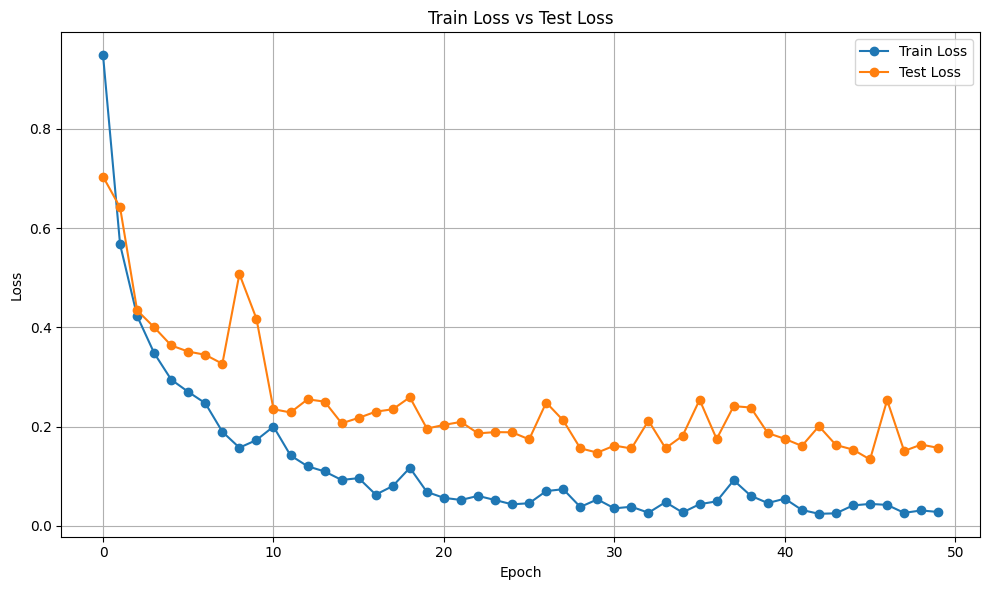

In [39]:
# ----------------------------------------------------------------------------------------------------------------

# ||||||||||||||||||| LOSS CURVE FOR OVERFITTING CHECKS |||||||||||||||||||||||


plt.figure(figsize=(10, 6))
plt.plot(results['train_loss'], label='Train Loss', marker='o')
plt.plot(results['test_loss'], label='Test Loss', marker='o')
plt.title('Train Loss vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Model Metrics

In [42]:

# ----------------------------------------------------------------------------------------------------------------

# ||||||||||||||||||| METRIC RESULTS |||||||||||||||||||||||

model_vo = device = "cuda" if torch.cuda.is_available() else 'cpu'
model_vo = TinyVGG(3,10,4).to(device) # Throwing model to GPU, if available
state_dict = torch.load("best_model.pth")
model_vo.load_state_dict(state_dict)
model_vo.eval()

# Lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

print("\nCollecting predictions from the test set...")
with torch.inference_mode(): # Use inference_mode for efficient evaluation
    for X, y in tqdm(test_dataloader, desc="Predicting on Test Data"):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred_logits = model_vo(X)

        # Get predicted class (index of the max logit)
        y_pred_class = torch.argmax(y_pred_logits, dim=1)

        # Append to lists
        all_true_labels.extend(y.cpu().numpy()) # Move to CPU and convert to NumPy
        all_predicted_labels.extend(y_pred_class.cpu().numpy()) # Move to CPU and convert to NumPy

# Convert lists to NumPy arrays for scikit-learn metrics
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

print("\n--- Performance Metrics on Test Set ---")

# 1. Classification Report (most comprehensive summary)
# 'target_names' are optional but make the report much more readable
# Replace ['Class 0', 'Class 1', 'Class 2', 'Class 3'] with your actual class names if available
target_names = [f'Class {i}' for i in range(4)]
print("Classification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=target_names))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
# Rows are true labels, columns are predicted labels
# Example: cm[i, j] is the number of times true class i was predicted as class j
cm = confusion_matrix(all_true_labels, all_predicted_labels)
print(cm)

# Optional: Individual metrics
print(f"\nIndividual Metrics (Weighted Average):")
# 'weighted' average accounts for class imbalance
print(f"F1 Score (weighted): {f1_score(all_true_labels, all_predicted_labels, average='weighted'):.4f}")
print(f"Precision (weighted): {precision_score(all_true_labels, all_predicted_labels, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(all_true_labels, all_predicted_labels, average='weighted'):.4f}")

print(f"\nIndividual Metrics (Macro Average - treats all classes equally):")
# 'macro' average treats all classes equally, useful for imbalanced datasets
print(f"F1 Score (macro): {f1_score(all_true_labels, all_predicted_labels, average='macro'):.4f}")
print(f"Precision (macro): {precision_score(all_true_labels, all_predicted_labels, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(all_true_labels, all_predicted_labels, average='macro'):.4f}")

# If you want to see per-class F1 scores:
print("\nPer-Class F1 Scores:")
f1_per_class = f1_score(all_true_labels, all_predicted_labels, average=None)
for i, score in enumerate(f1_per_class):
    print(f"Class {i}: {score:.4f}")


Predicting on Test Data: 100%|██████████| 8/8 [00:00<00:00, 13.01it/s]


--- Performance Metrics on Test Set ---
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.92      0.96        93
     Class 1       1.00      1.00      1.00        54
     Class 2       0.87      0.98      0.92        46
     Class 3       1.00      1.00      1.00        52

    accuracy                           0.97       245
   macro avg       0.96      0.98      0.97       245
weighted avg       0.97      0.97      0.97       245


Confusion Matrix:
[[86  0  7  0]
 [ 0 54  0  0]
 [ 1  0 45  0]
 [ 0  0  0 52]]

Individual Metrics (Weighted Average):
F1 Score (weighted): 0.9678
Precision (weighted): 0.9704
Recall (weighted): 0.9673

Individual Metrics (Macro Average - treats all classes equally):
F1 Score (macro): 0.9685
Precision (macro): 0.9635
Recall (macro): 0.9757

Per-Class F1 Scores:
Class 0: 0.9556
Class 1: 1.0000
Class 2: 0.9184
Class 3: 1.0000


# Save the metrics result

In [ ]:
# Prepare metrics dictionary
metrics = {
    "classification_report": classification_report(
        all_true_labels, all_predicted_labels, target_names=target_names, output_dict=True
    ),
    "confusion_matrix": cm.tolist(),
    "f1_score_weighted": f1_score(all_true_labels, all_predicted_labels, average='weighted'),
    "precision_weighted": precision_score(all_true_labels, all_predicted_labels, average='weighted'),
    "recall_weighted": recall_score(all_true_labels, all_predicted_labels, average='weighted'),
    "f1_score_macro": f1_score(all_true_labels, all_predicted_labels, average='macro'),
    "precision_macro": precision_score(all_true_labels, all_predicted_labels, average='macro'),
    "recall_macro": recall_score(all_true_labels, all_predicted_labels, average='macro'),
    "f1_per_class": f1_per_class.tolist(),
}

# Ensure the output directory exists
output_dir = Path("Challenge #1\docs\cards")
output_dir.mkdir(parents=True, exist_ok=True)


print(f"Metrics saved to {output_dir / 'ml-metrics.json'}")

Metrics saved to Challenge #1\docs\cards\ml-metrics.json


In [46]:
metrics# Save to JSON
with open(output_dir / "ml-metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)


In [47]:
metrics

{'classification_report': {'Class 0': {'precision': 0.9885057471264368,
   'recall': 0.9247311827956989,
   'f1-score': 0.9555555555555556,
   'support': 93.0},
  'Class 1': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 54.0},
  'Class 2': {'precision': 0.8653846153846154,
   'recall': 0.9782608695652174,
   'f1-score': 0.9183673469387755,
   'support': 46.0},
  'Class 3': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 52.0},
  'accuracy': 0.9673469387755103,
  'macro avg': {'precision': 0.963472590627763,
   'recall': 0.9757480130902291,
   'f1-score': 0.9684807256235828,
   'support': 245.0},
  'weighted avg': {'precision': 0.9703621501651059,
   'recall': 0.9673469387755103,
   'f1-score': 0.9678023045953076,
   'support': 245.0}},
 'confusion_matrix': [[86, 0, 7, 0],
  [0, 54, 0, 0],
  [1, 0, 45, 0],
  [0, 0, 0, 52]],
 'f1_score_weighted': 0.9678023045953076,
 'precision_weighted': 0.9703621501651059,
 'recall_weighted': 0.9673469387

In [48]:
from torchview import draw_graph

# Instantiate your model
model_vo_ = TinyVGG(3, 10, 4)

# Visualize the model architecture
model_graph = draw_graph(
    model_vo_,
    input_size=(1, 3, 224, 224),  # batch size 1, 3 channels, 224x224 image
    expand_nested=True,
    save_graph=True,
    directory="Challenge #1/docs/cards",
    filename="tinyvgg_architecture"
)
model_graph.visual_graph  # This will display the diagram in the notebook (if supported)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH